# Property Rent Modelling

## Purpose

Train property-level rent prediction models (Linear Regression, Random Forest, XGBoost) using integrated domain and SA2-level features, and generate baseline weekly rent predictions for 2025.

## Inputs
- `domain_combined_all_with_sa2_features.csv` – property and SA2-level features (distances, amenities, demographics, crime, income, population)

## Outputs
- `baseline_rent_predictions_2025.csv` – predicted weekly rents for each property
- Feature importance plots and model performance metrics (R², RMSE)

## Key Steps
1. Create indicator variables for amenities within capped distances.
2. Impute missing distances and travel times.
3. Select relevant features based on correlation analysis.
4. Split data into train, validation, and test sets (stratified by property type).
5. Train multiple models (Linear Regression, Random Forest, XGBoost) and tune hyperparameters.
6. Evaluate models on test set and compare performance.
7. Train final XGBoost model on full dataset and output baseline rent predictions.

In [ ]:
# libraries
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, r2_score

## Data quality Check Before Modeling

In [3]:
# Read data
domain_df = pd.read_csv("../../datasets/raw/cleaned/curated/domain_combined_all_with_sa2_features.csv")
domain_df.columns

Index(['sa2_code', 'sa2_name', 'suburb', 'postcode', 'weekly_rent', 'bond',
       'address', 'lat', 'lon', 'bedrooms', 'bathrooms', 'carspaces',
       'property_type', 'balcony', 'car_parking', 'heating',
       'air_conditioning', 'builtin_wardrobes', 'swimming_pool', 'ensuite',
       'dishwasher', 'garden', 'gym', 'pets_allowed', 'gas', 'intercom',
       'security_system', 'washing_machine', 'property_type_grouped',
       'distance_supermarket_m', 'travel_time_supermarket_mins',
       'distance_train_station_m', 'travel_time_train_station_mins',
       'distance_school_m', 'travel_time_school_mins', 'distance_healthcare_m',
       'travel_time_healthcare_mins', 'distance_cbd_m', 'travel_time_cbd_mins',
       'crime_rate_sa2_2025', 'sa2_erp_2025',
       'sa2_pop_density_2025_people_per_km2', 'sa2_pop_growth_2020_2024',
       'sa2_median_historical_growth', 'sa2_erp_change_per_cent_2023_24',
       'sa2_median_income_cagr', 'sa2_predicted_median_income_25'],
      dtype='objec

In [4]:
# Create indicator columns: Note the cap for supermarket/train = 3 km radius, school/healthcare = 15 km
domain_df['supermarket_nearby'] = domain_df['distance_supermarket_m'].notna().astype(int)
domain_df['train_station_nearby'] = domain_df['distance_train_station_m'].notna().astype(int)
domain_df['school_nearby'] = domain_df['distance_school_m'].notna().astype(int)
domain_df['healthcare_nearby'] = domain_df['distance_healthcare_m'].notna().astype(int)
domain_df

,sa2_code,sa2_name,suburb,postcode,weekly_rent,bond,address,lat,lon,bedrooms,bathrooms,carspaces,property_type,balcony,car_parking,heating,air_conditioning,builtin_wardrobes,swimming_pool,ensuite,dishwasher,garden,gym,pets_allowed,gas,intercom,security_system,washing_machine,property_type_grouped,distance_supermarket_m,travel_time_supermarket_mins,distance_train_station_m,travel_time_train_station_mins,distance_school_m,travel_time_school_mins,distance_healthcare_m,travel_time_healthcare_mins,distance_cbd_m,travel_time_cbd_mins,crime_rate_sa2_2025,sa2_erp_2025,sa2_pop_density_2025_people_per_km2,sa2_pop_growth_2020_2024,sa2_median_historical_growth,sa2_erp_change_per_cent_2023_24,sa2_median_income_cagr,sa2_predicted_median_income_25,supermarket_nearby,train_station_nearby,school_nearby,healthcare_nearby
0,213021344,Newport,SOUTH KINGSVILLE,3015,460.0,1994.0,3/53 Greene Street,-37.830982,144.87091,2,1,2,Apartment / Unit / Flat,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,Apartment,1774.0,5.633333,1928.0,5.033333,1060.74,3.023333,2427.16,4.265500,11051.07,17.002833,6491.469850,20138.014352,2277.875547,2.724838,4.891701,2.3348,3.920093,85258.92381,1,1,1,1
1,213021344,Newport,SOUTH KINGSVILLE,3015,400.0,1738.0,1/3 New Street,-37.826218,144.86755,2,1,1,Apartment / Unit / Flat,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,Apartment,2051.0,5.883333,2205.0,5.283333,1401.92,4.150000,2549.43,4.859167,11392.26,18.070500,6491.469850,20138.014352,2277.875547,2.724838,4.891701,2.3348,3.920093,85258.92381,1,1,1,1
2,213021343,Altona North,SOUTH KINGSVILLE,3015,795.0,3454.0,19/92 New Street,-37.831226,144.86632,3,2,3,Townhouse,1,0,1,1,1,0,1,1,0,0,1,1,0,0,1,Townhouse,2969.0,5.983333,2318.0,5.416667,1449.81,3.266167,1983.01,3.499833,11440.15,18.458167,6491.469850,16287.171760,1006.350051,3.364510,4.702436,3.4317,4.220320,70070.10476,1,1,1,1
3,213021344,Newport,SOUTH KINGSVILLE,3015,675.0,2933.0,3/14 Saltley Street,-37.827423,144.86768,3,1,2,Townhouse,1,1,1,1,1,0,0,1,0,0,0,0,0,0,0,Townhouse,1831.0,5.566667,1985.0,4.983333,1118.54,3.500167,2504.92,4.791500,11108.88,17.420833,6491.469850,20138.014352,2277.875547,2.724838,4.891701,2.3348,3.920093,85258.92381,1,1,1,1
4,213021344,Newport,SOUTH KINGSVILLE,3015,450.0,1955.0,4/2B Saltley Street,-37.826270,144.86790,2,1,0,Apartment / Unit / Flat,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,Apartment,2127.0,6.100000,2281.0,5.500000,1320.59,3.875667,2630.75,5.133500,11310.93,17.796333,6491.469850,20138.014352,2277.875547,2.724838,4.891701,2.3348,3.920093,85258.92381,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12611,208011169,Brighton (Vic.),BRIGHTON,3186,1575.0,6300.0,NaN,-37.912884,144.99155,2,2,1,Apartment / Unit / Flat,1,0,1,1,1,0,1,1,0,0,1,0,0,0,1,Apartment,NaN,NaN,NaN,NaN,287.98,0.878333,122.13,0.435500,11753.90,23.569167,4332.175278,23868.016490,2910.591738,-0.120152,0.364024,2.3174,5.161190,80802.13333,0,0,1,1
12612,208011169,Brighton (Vic.),BRIGHTON,3186,2625.0,10500.0,2/71 Roslyn Street,-37.922750,145.00224,4,2,2,Townhouse,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Townhouse,1301.0,2.533333,1716.0,4.516667,745.22,2.914333,1178.48,3.262167,13778.69,27.421500,4332.175278,23868.016490,2910.591738,-0.120152,0.364024,2.3174,5.161190,80802.13333,1,1,1,1
12613,208011169,Brighton (Vic.),BRIGHTON,3186,2200.0,13200.0,23 Bay Street,-37.903280,144.98697,5,3,3,House,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,House,1038.0,2.466667,1496.0,4.233333,1190.17,2.704500,1432.40,2.436667,10555.39,21.645833,4332.175278,23868.016490,2910.591738,-0.120152,0.364024,2.3174,5.161190,80802.13333,1,1,1,1
12614,208011169,Brighton (Vic.),BRIGHTON,3186,1390.0,8340.0,2/7B Wilson Street,-37.909650,144.99810,3,3,2,Townhouse,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Townhouse,966.0,1.750000,820.0,2.083333,250.74,0.856833,601.44,2.162333,11161.98,23.214667,4332.175278,23868.016490,2910.591738,-0.120152,0.364024,2.3174,5.161190,80802.13333,1,1,1,1


In [ ]:
imputed_df = domain_df.copy()
# define caps (metres)
caps = {
    'supermarket': 3100,
    'train_station': 3100,
    'school': 15100,
    'healthcare': 15100
}

# compute & fill missing distances and times
for facility, cap_value in caps.items():
    dist_col = f'distance_{facility}_m'
    time_col = f'travel_time_{facility}_mins'
    
    # Estimate avg speed based on valid rows 
    valid_mask = imputed_df[dist_col].notna() & imputed_df[time_col].notna() & (imputed_df[time_col] > 0)
    avg_speed = (imputed_df.loc[valid_mask, dist_col] / imputed_df.loc[valid_mask, time_col]).mean()
    
    # Impute distances with fixed cap
    imputed_df.loc[imputed_df[dist_col].isna(), dist_col] = cap_value
    
    # Impute travel times based on avg speed
    imputed_df.loc[imputed_df[time_col].isna(), time_col] = imputed_df.loc[imputed_df[time_col].isna(), dist_col] / avg_speed
    
    print(f"{facility}: capped missing dist at {cap_value} m, avg_speed ≈ {avg_speed:.1f} m/min")

supermarket: capped missing dist at 3100 m, avg_speed ≈ 379.6 m/min
train_station: capped missing dist at 3100 m, avg_speed ≈ 392.2 m/min
school: capped missing dist at 15100 m, avg_speed ≈ 434.6 m/min
healthcare: capped missing dist at 15100 m, avg_speed ≈ 480.8 m/min


## Modelling

In [ ]:
domain_modelling = imputed_df.copy()

Index(['sa2_code', 'sa2_name', 'suburb', 'postcode', 'weekly_rent', 'bond',
       'address', 'lat', 'lon', 'bedrooms', 'bathrooms', 'carspaces',
       'property_type', 'balcony', 'car_parking', 'heating',
       'air_conditioning', 'builtin_wardrobes', 'swimming_pool', 'ensuite',
       'dishwasher', 'garden', 'gym', 'pets_allowed', 'gas', 'intercom',
       'security_system', 'washing_machine', 'property_type_grouped',
       'distance_supermarket_m', 'travel_time_supermarket_mins',
       'distance_train_station_m', 'travel_time_train_station_mins',
       'distance_school_m', 'travel_time_school_mins', 'distance_healthcare_m',
       'travel_time_healthcare_mins', 'distance_cbd_m', 'travel_time_cbd_mins',
       'crime_rate_sa2_2025', 'sa2_erp_2025',
       'sa2_pop_density_2025_people_per_km2', 'sa2_pop_growth_2020_2024',
       'sa2_median_historical_growth', 'sa2_erp_change_per_cent_2023_24',
       'sa2_median_income_cagr', 'sa2_predicted_median_income_25',
       'supermarket

In [12]:
cols_to_drop = ["sa2_code", "bond", "address", "sa2_name", "suburb", "postcode", "lat", "lon", "property_type"]
domain_modelling = domain_modelling.drop(columns=cols_to_drop)

## Finalize final feature set 

In [13]:
# property-level features and the target
features = ["bedrooms", "bathrooms", "carspaces", "balcony", "car_parking", "heating", "air_conditioning",
    "builtin_wardrobes", "swimming_pool", "ensuite", "dishwasher", "garden", "gym", "pets_allowed", "gas", "intercom", "security_system", "washing_machine",
    "distance_supermarket_m", "distance_train_station_m", "distance_school_m", "distance_healthcare_m",
    "distance_cbd_m", "travel_time_supermarket_mins", "travel_time_school_mins", "travel_time_train_station_mins",
    "travel_time_healthcare_mins", "travel_time_cbd_mins"]

target = "weekly_rent"

# create dataframe with listed columns including target
corr_df = domain_modelling[features + [target]]

# Compute the correlation matrix
corr_matrix = corr_df.corr()


# Find out which columns (more highly correlated with rent price)
high_corr_pairs = [
    (i, j, corr_matrix.loc[i, j])
    for i in corr_matrix.columns
    for j in corr_matrix.columns
    if i != j and abs(corr_matrix.loc[i, j]) > 0.7
]

for i, j, val in high_corr_pairs:
    print(f"{i} — {j}: {val:.2f}")
    
amenities = ["supermarket", "train_station", "school", "healthcare", "cbd"]
keep_cols = []


for a in amenities:
    dist_col = f"distance_{a}_m"
    time_col = f"travel_time_{a}_mins"

    dist_corr = abs(domain_modelling[dist_col].corr(domain_modelling["weekly_rent"]))
    time_corr = abs(domain_modelling[time_col].corr(domain_modelling["weekly_rent"]))

    if dist_corr >= time_corr:
        keep_cols.append(dist_col)
    else:
        keep_cols.append(time_col)

print("Keep these columns based on higher correlation with price:")
print(keep_cols)


# Drop the columns we don't want
drop_cols = [
    "travel_time_supermarket_mins",
    "travel_time_train_station_mins",
    "travel_time_school_mins",
    "travel_time_healthcare_mins",
    "distance_cbd_m"]
domain_modelling = domain_modelling.drop(columns=drop_cols)

distance_supermarket_m — travel_time_supermarket_mins: 0.89
distance_train_station_m — travel_time_train_station_mins: 0.85
distance_school_m — travel_time_school_mins: 0.91
distance_healthcare_m — travel_time_healthcare_mins: 0.93
distance_cbd_m — travel_time_cbd_mins: 0.99
travel_time_supermarket_mins — distance_supermarket_m: 0.89
travel_time_school_mins — distance_school_m: 0.91
travel_time_train_station_mins — distance_train_station_m: 0.85
travel_time_healthcare_mins — distance_healthcare_m: 0.93
travel_time_cbd_mins — distance_cbd_m: 0.99
Keep these columns based on higher correlation with price:
['distance_supermarket_m', 'distance_train_station_m', 'distance_school_m', 'distance_healthcare_m', 'travel_time_cbd_mins']


In [14]:
# List of SA2-level features
sa2_features = [
    "sa2_erp_2025",
    "sa2_pop_density_2025_people_per_km2",
    "sa2_pop_growth_2020_2024",
    "sa2_median_historical_growth",
    "sa2_erp_change_per_cent_2023_24",
    "sa2_median_income_cagr",
    "sa2_predicted_median_income_25",
    "crime_rate_sa2_2025",
]

# Compute correlation matrix for SA2 features
corr_matrix_sa2 = domain_modelling[sa2_features + ["weekly_rent"]].corr()

# Correlation with target
corr_with_target = corr_matrix_sa2["weekly_rent"].abs()

# Threshold for high correlation
threshold = 0.7

# Find highly correlated pairs (excluding self-correlation)
high_corr_pairs = [
    (i, j, corr_matrix_sa2.loc[i, j])
    for i in sa2_features
    for j in sa2_features
    if i != j and abs(corr_matrix_sa2.loc[i, j]) > threshold
]

# Keep track of dropped features
dropped_features = set()

for i, j, val in high_corr_pairs:
    if i in dropped_features or j in dropped_features:
        continue
    # Compare correlation with target and drop the lower one
    if corr_with_target[i] < corr_with_target[j]:
        dropped_features.add(i)
    else:
        dropped_features.add(j)

print("SA2 features to drop due to high correlation:", dropped_features)

# Drop from DataFrame
domain_modelling = domain_modelling.drop(columns=list(dropped_features))

SA2 features to drop due to high correlation: {'sa2_median_historical_growth', 'sa2_erp_change_per_cent_2023_24'}


## Retrain on the new set with interaction included


### Random Forest 

Train R² (log): 0.964
Val   R² (log): 0.752
Test R² (log):  0.741
Test RMSE ($):  151.17


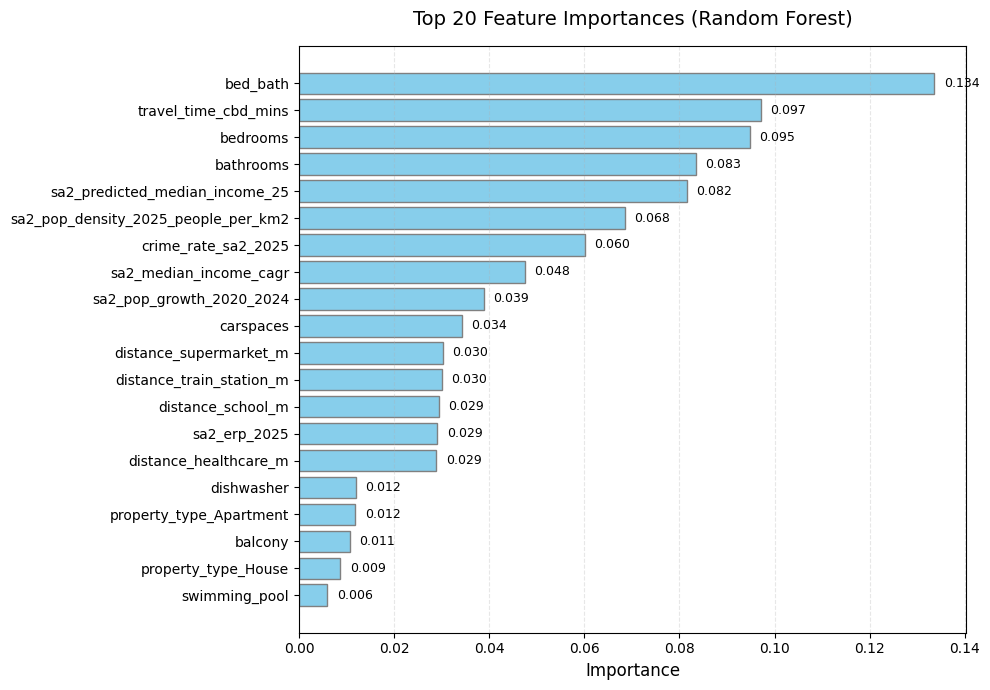

In [15]:
# Prepare data
X = domain_modelling.drop(columns=["weekly_rent"])
y = domain_modelling["weekly_rent"]

# Log-transform target
y_log = np.log1p(y)

# 60% train, 20% val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=27,
    stratify=X["property_type_grouped"]
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=27,
    stratify=X_temp["property_type_grouped"]
)

# One-hot encode property_type_grouped
X_train = pd.get_dummies(X_train, columns=["property_type_grouped"], prefix="property_type")
X_val = pd.get_dummies(X_val, columns=["property_type_grouped"], prefix="property_type")
X_test = pd.get_dummies(X_test, columns=["property_type_grouped"], prefix="property_type")

# Align columns in case some categories exist in train but not in val
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Interaction
X_train["bed_bath"] = X_train["bedrooms"] * X_train["bathrooms"]
X_val["bed_bath"]   = X_val["bedrooms"]   * X_val["bathrooms"]
X_test["bed_bath"]  = X_test["bedrooms"]  * X_test["bathrooms"]

# Train base RF model 
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# Evaluate on train & val 
y_pred_val_log = rf.predict(X_val)
y_pred_train_log = rf.predict(X_train)

train_r2 = r2_score(y_train, y_pred_train_log)
val_r2 = r2_score(y_val, y_pred_val_log)

print(f"Train R² (log): {train_r2:.3f}")
print(f"Val   R² (log): {val_r2:.3f}")

# Retrain on Train + Val for final model
X_fulltrain = pd.concat([X_train, X_val])
y_fulltrain = pd.concat([y_train, y_val])

rf_final = RandomForestRegressor(**rf.get_params())
rf_final.fit(X_fulltrain, y_fulltrain)

# Evaluate final model on Test set 
y_pred_test_log_rf = rf_final.predict(X_test)
y_pred_test_real_rf = np.expm1(y_pred_test_log_rf)
y_test_real_rf = np.expm1(y_test)

test_r2_log_rf = r2_score(y_test, y_pred_test_log_rf)
test_rmse_real_rf = np.sqrt(mean_squared_error(y_test_real_rf, y_pred_test_real_rf))

print(f"Test R² (log):  {test_r2_log_rf:.3f}")
print(f"Test RMSE ($):  {test_rmse_real_rf:.2f}")


feature_names = X_fulltrain.columns  
importances = rf_final.feature_importances_

feat_imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 7))
bars = plt.barh(
    y=np.arange(len(feat_imp_df)), 
    width=feat_imp_df["importance"], 
    color="skyblue", 
    edgecolor="gray"
)

plt.yticks(np.arange(len(feat_imp_df)), feat_imp_df["feature"], fontsize=10)
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances (Random Forest)", fontsize=14, pad=15)
plt.xlabel("Importance", fontsize=12)
plt.grid(alpha=0.3, linestyle="--", axis="x")

for i, v in enumerate(feat_imp_df["importance"]):
    plt.text(v + 0.002, i, f"{v:.3f}", va="center", fontsize=9)

plt.tight_layout()
plt.show()


### XGBoost

In [16]:
# Split data
X = domain_modelling.drop(columns=["weekly_rent"])
y = domain_modelling["weekly_rent"]

y_log = np.log1p(y)

# Split with stratification
X_temp, X_test, y_temp, y_test = train_test_split(X, y_log, test_size=0.2, random_state=27, stratify=X["property_type_grouped"])
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp, test_size=0.25, random_state=27, stratify=X_temp["property_type_grouped"])

# One-hot encode property_type_grouped
X_train = pd.get_dummies( X_train, columns=["property_type_grouped"], prefix="property_type")
X_val = pd.get_dummies(X_val, columns=["property_type_grouped"], prefix="property_type")
X_test = pd.get_dummies(X_test, columns=["property_type_grouped"], prefix="property_type")

# Align columns in case some categories exist in train but not in val
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# try interaction
X_train["bed_bath"] = X_train["bedrooms"] * X_train["bathrooms"]
X_val["bed_bath"]   = X_val["bedrooms"]   * X_val["bathrooms"]
X_test["bed_bath"]  = X_test["bedrooms"]  * X_test["bathrooms"]


xgb_model = XGBRegressor(n_estimators=3000, learning_rate=0.01, max_depth=8, min_child_weight=5,  subsample=0.8, colsample_bytree=0.6, reg_alpha=0.3,  reg_lambda=1.0,
    gamma=0, random_state=42, n_jobs=-1,)


xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    early_stopping_rounds=50,
    verbose=True,
)

# Evaluate on train & val 
y_pred_val_log = xgb_model.predict(X_val)
y_pred_train_log = xgb_model.predict(X_train)

train_r2 = r2_score(y_train, y_pred_train_log)
val_r2 = r2_score(y_val, y_pred_val_log)

print(f"Train R² (log): {train_r2:.3f}")
print(f"Val   R² (log): {val_r2:.3f}")

#  Retrain on Train + Val for final model
X_fulltrain = pd.concat([X_train, X_val])
y_fulltrain = pd.concat([y_train, y_val])

xgb_final = XGBRegressor(**xgb_model.get_params())
xgb_final.fit(X_fulltrain, y_fulltrain, verbose=False)

#  Evaluate final model on Test set 
y_pred_test_log_xgb = xgb_final.predict(X_test)
y_pred_test_real_xgb = np.expm1(y_pred_test_log_xgb)
y_test_real_xgb = np.expm1(y_test)

test_r2_log_xgb = r2_score(y_test, y_pred_test_log_xgb)
test_rmse_real_xgb = np.sqrt(mean_squared_error(y_test_real_xgb, y_pred_test_real_xgb))

print(f"Test R² (log):  {test_r2_log_xgb:.3f}")
print(f"Test RMSE ($):  {test_rmse_real_xgb:.2f}")

[0]	validation_0-rmse:5.83901
[1]	validation_0-rmse:5.78082
[2]	validation_0-rmse:5.72315
[3]	validation_0-rmse:5.66611
[4]	validation_0-rmse:5.60971
[5]	validation_0-rmse:5.55383
[6]	validation_0-rmse:5.49845
[7]	validation_0-rmse:5.44363
[8]	validation_0-rmse:5.38936
[9]	validation_0-rmse:5.33567
[10]	validation_0-rmse:5.28247
[11]	validation_0-rmse:5.22978
[12]	validation_0-rmse:5.17766
[13]	validation_0-rmse:5.12608
[14]	validation_0-rmse:5.07501
[15]	validation_0-rmse:5.02450
[16]	validation_0-rmse:4.97447
[17]	validation_0-rmse:4.92489
[18]	validation_0-rmse:4.87582
[19]	validation_0-rmse:4.82722
[20]	validation_0-rmse:4.77914
[21]	validation_0-rmse:4.73153
[22]	validation_0-rmse:4.68438
[23]	validation_0-rmse:4.63775
[24]	validation_0-rmse:4.59165
[25]	validation_0-rmse:4.54600
[26]	validation_0-rmse:4.50078
[27]	validation_0-rmse:4.45601
[28]	validation_0-rmse:4.41164
[29]	validation_0-rmse:4.36779
[30]	validation_0-rmse:4.32432
[31]	validation_0-rmse:4.28131
[32]	validation_0-

/Users/tasneemzulaiqa/Documents/GitHub/project-2-group-real-estate-industry-project-7-2025/proj2_env/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/tasneemzulaiqa/Documents/GitHub/project-2-group-real-estate-industry-project-7-2025/proj2_env/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[41]	validation_0-rmse:3.87417
[42]	validation_0-rmse:3.83568
[43]	validation_0-rmse:3.79755
[44]	validation_0-rmse:3.75982
[45]	validation_0-rmse:3.72254
[46]	validation_0-rmse:3.68553
[47]	validation_0-rmse:3.64895
[48]	validation_0-rmse:3.61275
[49]	validation_0-rmse:3.57691
[50]	validation_0-rmse:3.54141
[51]	validation_0-rmse:3.50627
[52]	validation_0-rmse:3.47149
[53]	validation_0-rmse:3.43712
[54]	validation_0-rmse:3.40296
[55]	validation_0-rmse:3.36920
[56]	validation_0-rmse:3.33573
[57]	validation_0-rmse:3.30263
[58]	validation_0-rmse:3.26991
[59]	validation_0-rmse:3.23752
[60]	validation_0-rmse:3.20543
[61]	validation_0-rmse:3.17361
[62]	validation_0-rmse:3.14217
[63]	validation_0-rmse:3.11103
[64]	validation_0-rmse:3.08017
[65]	validation_0-rmse:3.04968
[66]	validation_0-rmse:3.01948
[67]	validation_0-rmse:2.98961
[68]	validation_0-rmse:2.95999
[69]	validation_0-rmse:2.93070
[70]	validation_0-rmse:2.90165
[71]	validation_0-rmse:2.87289
[72]	validation_0-rmse:2.84446
[73]	val

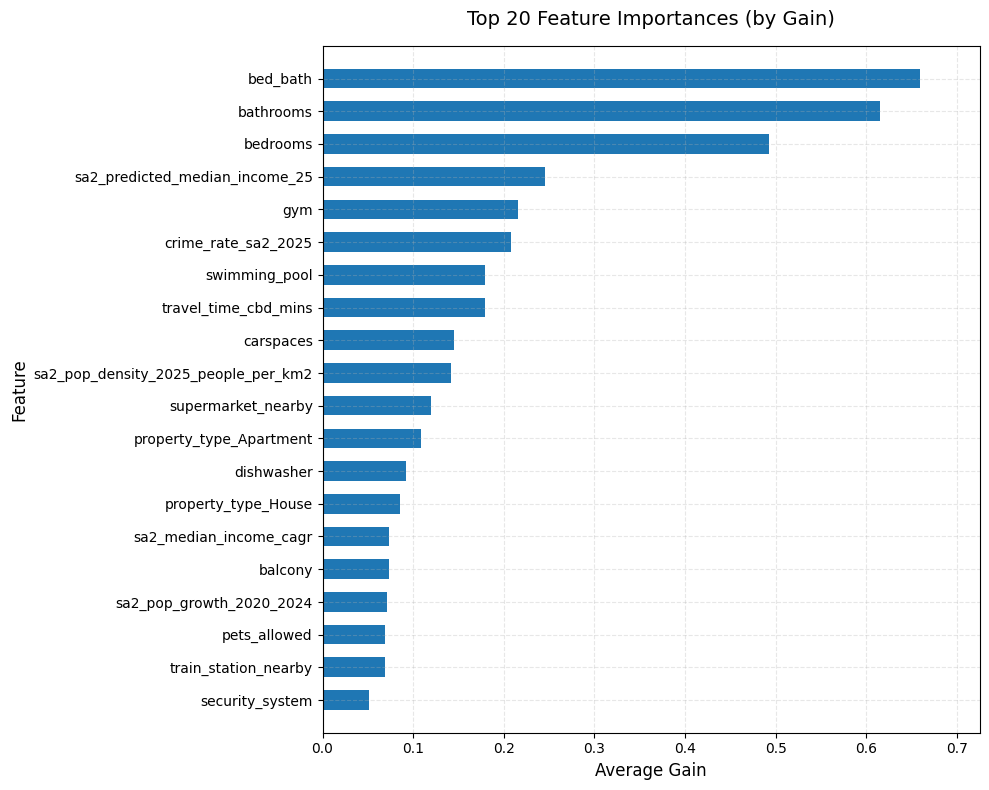

In [17]:
# Plot top 20 features by gain
fig, ax = plt.subplots(figsize=(10, 8))

plot_importance(
    xgb_final, 
    ax=ax, 
    max_num_features=20, 
    importance_type="gain", 
    height=0.6, 
    show_values=False  
)

ax.set_title("Top 20 Feature Importances (by Gain)", fontsize=14, pad=15)
ax.set_xlabel("Average Gain", fontsize=12)
ax.set_ylabel("Feature", fontsize=12)
ax.grid(alpha=0.3, linestyle="--")

for label in ax.get_yticklabels():
    label.set_fontsize(10)

plt.tight_layout()
plt.show()

### Hyperparameter tuning for XGBoost

In [ ]:
# Define model
xgb = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=2000,
    learning_rate=0.03,
    random_state=42,
    n_jobs=-1
)

# Define parameter grid
param_dist = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_child_weight': [1, 3, 5, 7, 10],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.1, 0.3, 0.5, 1.0],
    'reg_lambda': [0.5, 1.0, 1.5, 2.0],
    'learning_rate': [0.01, 0.02, 0.03, 0.05, 0.1],
}

# Define search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=60,  # you can increase to 100 for more thorough search
    scoring=make_scorer(r2_score),
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit on train + validation set (log-transformed target)
X_tune = pd.concat([X_train, X_val])
y_tune = pd.concat([y_train, y_val])

random_search.fit(X_tune, y_tune)

print("Best CV R²:", random_search.best_score_)
print("Best hyperparameters:", random_search.best_params_)

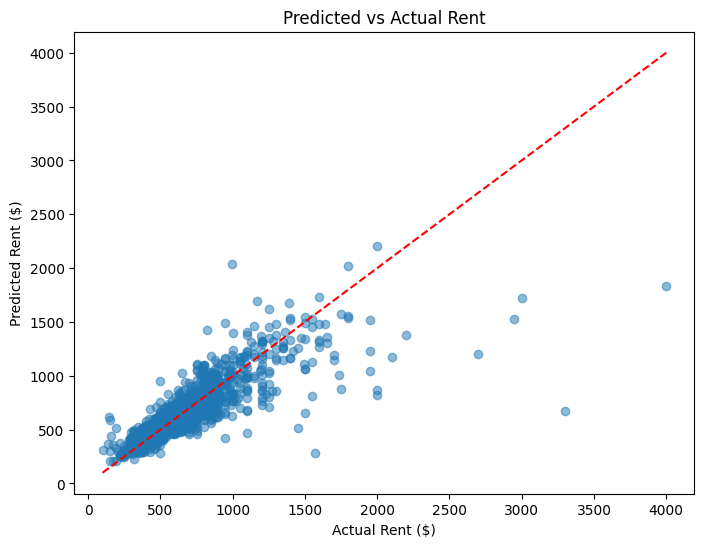

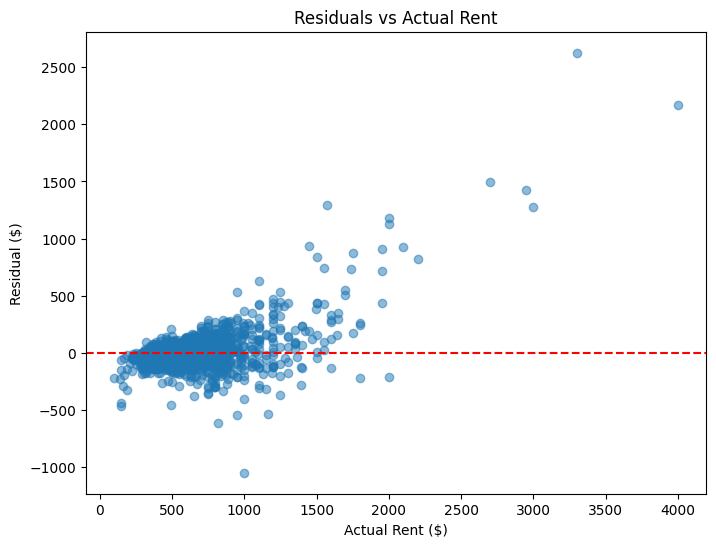

In [19]:
# Predicted and actual rents in real dollars
y_test_real = np.expm1(y_test)
y_pred_real = np.expm1(y_pred_test_log_xgb)

# Residuals
residuals = y_test_real - y_pred_real

# Predicted vs Actual
plt.figure(figsize=(8,6))
plt.scatter(y_test_real, y_pred_real, alpha=0.5)
plt.plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], 'r--')
plt.xlabel("Actual Rent ($)")
plt.ylabel("Predicted Rent ($)")
plt.title("Predicted vs Actual Rent")
plt.show()

# Residuals vs Actual
plt.figure(figsize=(8,6))
plt.scatter(y_test_real, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Actual Rent ($)")
plt.ylabel("Residual ($)")
plt.title("Residuals vs Actual Rent")
plt.show()

### Linear Models 

In [20]:
# Scale continuous features 
continuous_features = [
    "distance_supermarket_m", "distance_train_station_m", "distance_school_m",
    "distance_healthcare_m", "travel_time_cbd_mins", "bedrooms", "bathrooms",
    "carspaces", "crime_rate_sa2_2025", "sa2_erp_2025",
    "sa2_pop_density_2025_people_per_km2", "sa2_pop_growth_2020_2024",
    "sa2_predicted_median_income_25", "bed_bath"
]

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[continuous_features] = scaler.fit_transform(X_train[continuous_features])
X_val_scaled[continuous_features] = scaler.transform(X_val[continuous_features])
X_test_scaled[continuous_features] = scaler.transform(X_test[continuous_features])


linreg_model = LinearRegression()

# Fit on training data 
linreg_model.fit(X_train_scaled, y_train)

# Evaluate on train & val 
y_pred_train_log = linreg_model.predict(X_train_scaled)
y_pred_val_log = linreg_model.predict(X_val_scaled)

train_r2 = r2_score(y_train, y_pred_train_log)
val_r2 = r2_score(y_val, y_pred_val_log)

print(f"Train R² (log): {train_r2:.3f}")
print(f"Val   R² (log): {val_r2:.3f}")

# Retrain on full (train + val) 
X_fulltrain_scaled = pd.concat([X_train_scaled, X_val_scaled])
y_fulltrain = pd.concat([y_train, y_val])

linreg_final = LinearRegression()
linreg_final.fit(X_fulltrain_scaled, y_fulltrain)

#  Evaluate on test set 
y_pred_test_log_lr = linreg_final.predict(X_test_scaled)
y_pred_test_real_lr = np.expm1(y_pred_test_log_lr)
y_test_real_lr = np.expm1(y_test)

test_r2_log_lr = r2_score(y_test, y_pred_test_log_lr)
test_rmse_real_lr = np.sqrt(mean_squared_error(y_test_real_lr, y_pred_test_real_lr))

print(f"Test R² (log):  {test_r2_log_lr:.3f}")
print(f"Test RMSE ($):  {test_rmse_real_lr:.2f}")

Train R² (log): 0.525
Val   R² (log): 0.512
Test R² (log):  0.265
Test RMSE ($):  72498.48


## Performance graph R^2 

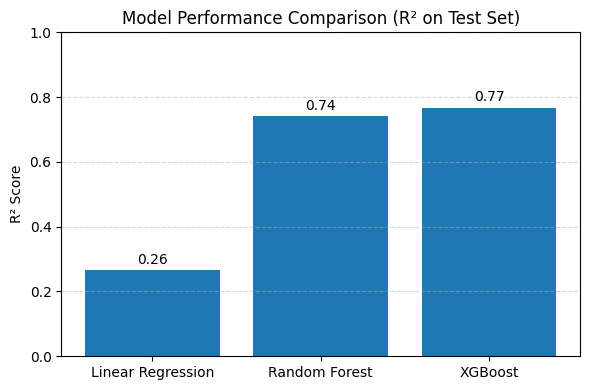

In [21]:
r2_scores = {
    "Linear Regression": test_r2_log_lr,  
    "Random Forest": test_r2_log_rf,          
    "XGBoost": test_r2_log_xgb,             
}

# Convert to DataFrame for easy plotting
r2_df = pd.DataFrame(list(r2_scores.items()), columns=["Model", "R²"])

# Plot
plt.figure(figsize=(6,4))
bars = plt.bar(r2_df["Model"], r2_df["R²"])

# Add value labels on bars
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 0.01,
        f"{bar.get_height():.2f}",
        ha='center', va='bottom', fontsize=10
    )

plt.title("Model Performance Comparison (R² on Test Set)")
plt.ylabel("R² Score")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Produce baseline prediction using XGBoost

In [22]:
# Prepare full dataset 
X_full = domain_modelling.drop(columns=["weekly_rent"])
y_full = np.log1p(domain_modelling["weekly_rent"])  

#  Feature engineering
X_full["bed_bath"] = X_full["bedrooms"] * X_full["bathrooms"]

# One-hot encode categorical variable 
X_full = pd.get_dummies(X_full, columns=["property_type_grouped"], prefix="property_type")

best_params = {
    'subsample': 0.8,
    'reg_lambda': 1.0,
    'reg_alpha': 0.3,
    'min_child_weight': 5,
    'max_depth': 8,
    'learning_rate': 0.01,
    'gamma': 0,
    'colsample_bytree': 0.6,
    'n_estimators': 3000,
    'objective': 'reg:squarederror',
    'random_state': 42,
    'n_jobs': -1
}

# Train final XGB model on full domain
xgb_final_full = XGBRegressor(**best_params)
xgb_final_full.fit(X_full, y_full, verbose=True) 

# Predict baseline rents 
y_pred_log_full = xgb_final_full.predict(X_full)
y_pred_real_full = np.expm1(y_pred_log_full)  


domain_df["predicted_weekly_rent"] = y_pred_real_full

# Quick check
print(domain_df[["weekly_rent", "predicted_weekly_rent"]].head())


   weekly_rent  predicted_weekly_rent
0        460.0             485.532898
1        400.0             449.437561
2        795.0             795.881165
3        675.0             656.813599
4        450.0             457.739655


In [23]:
domain_df.to_csv("../../datasets/results/baseline_rent_predictions_2025.csv", index=False)